In [1]:
from collections import defaultdict

import numpy as np
import stim
from matplotlib import pyplot as plt

## Circuit

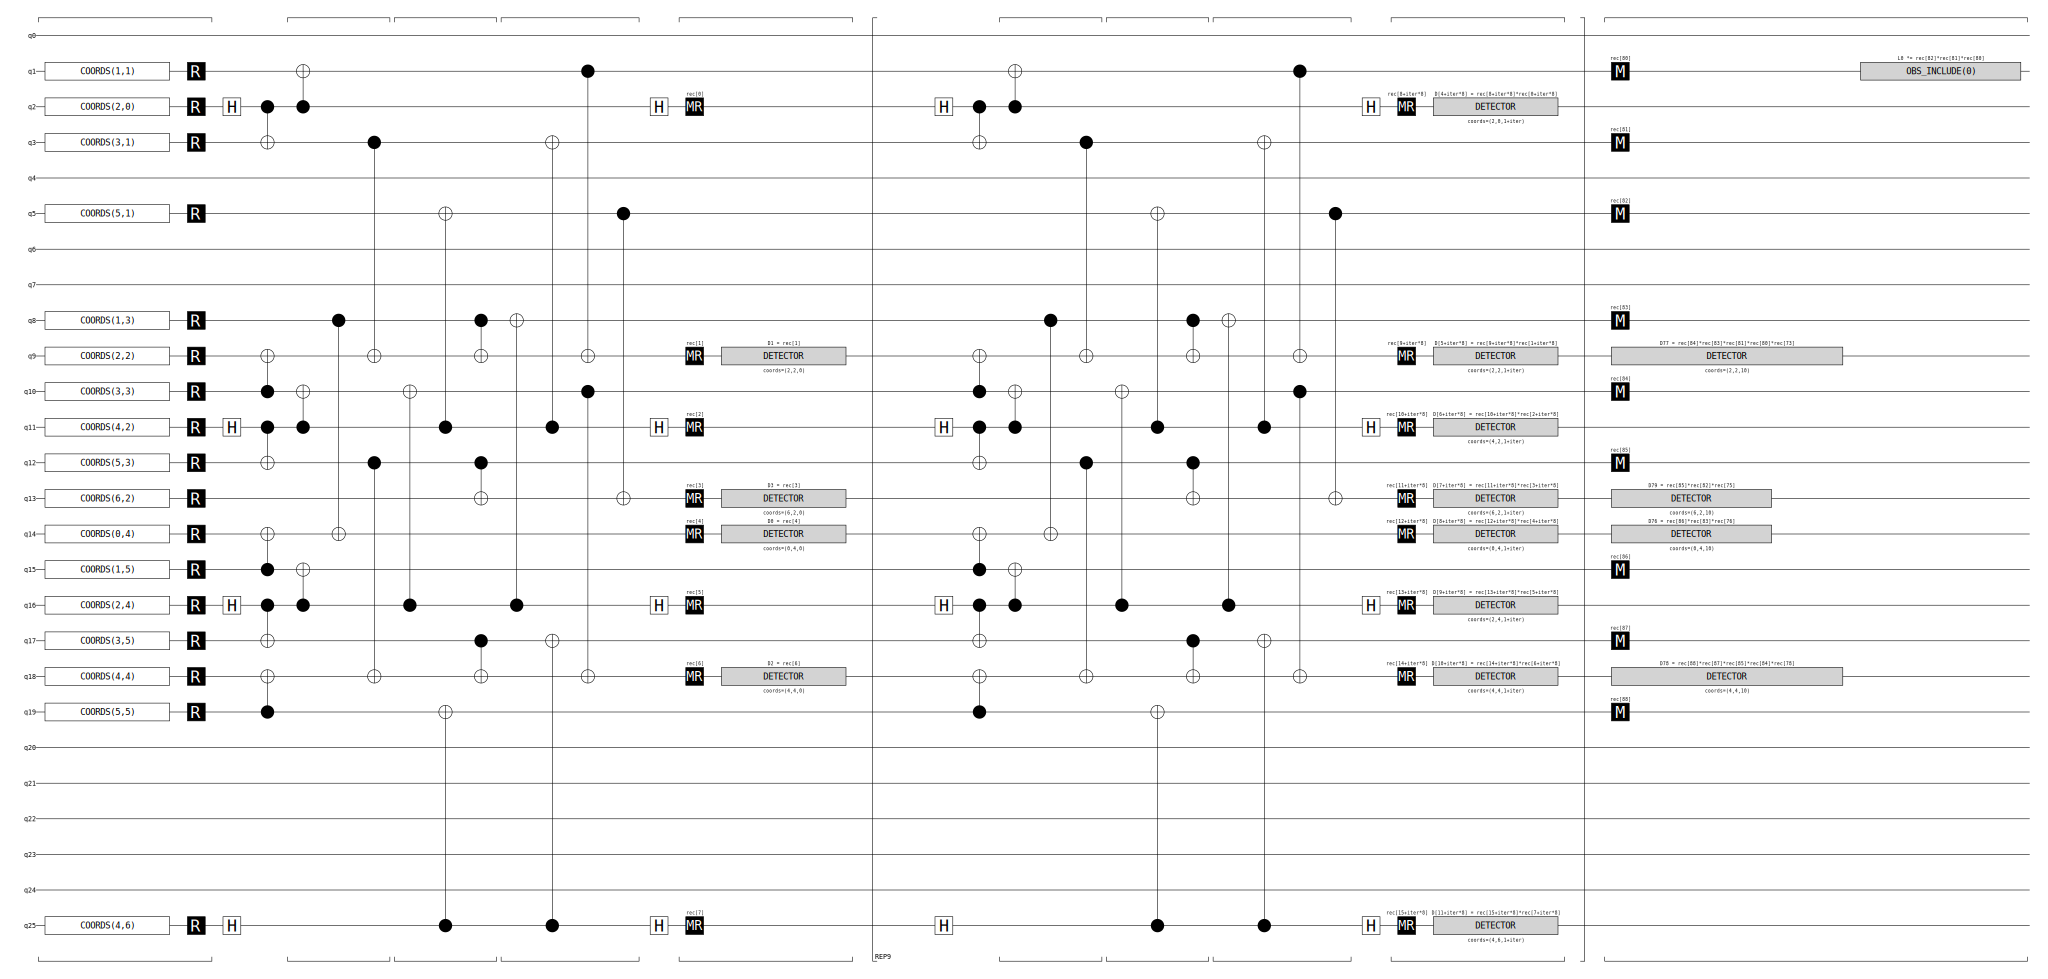

In [2]:
distance = 3
rounds = 10
noise = 0.004
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    distance=distance,
    rounds=rounds,
    after_clifford_depolarization=noise,
    after_reset_flip_probability=noise,
    before_measure_flip_probability=noise,
    before_round_data_depolarization=noise,
)
circuit.without_noise().diagram("timeline-svg")

In [3]:
coords = list(map(lambda x: list(map(int, x)), circuit.get_detector_coordinates().values()))
print(coords)

qubits = sorted(set((i[0], i[1]) for i in coords))
print(qubits)

[[0, 4, 0], [2, 2, 0], [4, 4, 0], [6, 2, 0], [2, 0, 1], [2, 2, 1], [4, 2, 1], [6, 2, 1], [0, 4, 1], [2, 4, 1], [4, 4, 1], [4, 6, 1], [2, 0, 2], [2, 2, 2], [4, 2, 2], [6, 2, 2], [0, 4, 2], [2, 4, 2], [4, 4, 2], [4, 6, 2], [2, 0, 3], [2, 2, 3], [4, 2, 3], [6, 2, 3], [0, 4, 3], [2, 4, 3], [4, 4, 3], [4, 6, 3], [2, 0, 4], [2, 2, 4], [4, 2, 4], [6, 2, 4], [0, 4, 4], [2, 4, 4], [4, 4, 4], [4, 6, 4], [2, 0, 5], [2, 2, 5], [4, 2, 5], [6, 2, 5], [0, 4, 5], [2, 4, 5], [4, 4, 5], [4, 6, 5], [2, 0, 6], [2, 2, 6], [4, 2, 6], [6, 2, 6], [0, 4, 6], [2, 4, 6], [4, 4, 6], [4, 6, 6], [2, 0, 7], [2, 2, 7], [4, 2, 7], [6, 2, 7], [0, 4, 7], [2, 4, 7], [4, 4, 7], [4, 6, 7], [2, 0, 8], [2, 2, 8], [4, 2, 8], [6, 2, 8], [0, 4, 8], [2, 4, 8], [4, 4, 8], [4, 6, 8], [2, 0, 9], [2, 2, 9], [4, 2, 9], [6, 2, 9], [0, 4, 9], [2, 4, 9], [4, 4, 9], [4, 6, 9], [0, 4, 10], [2, 2, 10], [4, 4, 10], [6, 2, 10]]
[(0, 4), (2, 0), (2, 2), (2, 4), (4, 2), (4, 4), (4, 6), (6, 2)]


## DEF

In [4]:
def calc_def(coords: list[list[int]], sample: np.ndarray, distance: int, rounds: int):
    res = defaultdict(list)
    for key, (i, j, _) in enumerate(coords):
        res[(i // 2, j // 2)].append(sample[key])

    heatmap = np.full((distance + 1, distance + 1), np.nan)
    for (i, j), val in res.items():
        if len(val) == rounds + 1:
            heatmap[i, j] = np.mean(val[1:-1])
        else:
            heatmap[i, j] = np.mean(val)

    for key, val in res.items():
        if len(val) == rounds + 1:
            res[key] = np.array([np.arange(rounds + 1), val])
        else:
            res[key] = np.array([np.arange(rounds - 1) + 1, val])

    return res, heatmap

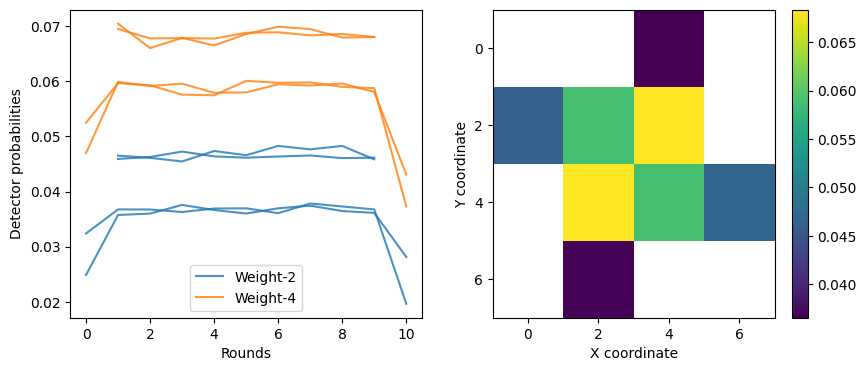

In [5]:
shots = 10**5
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots)
res, heatmap = calc_def(coords, detector_sample.mean(axis=0), distance, rounds)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for key, val in res.items():
    if 0 in key or distance in key:
        axs[0].plot(val[0], val[1], color="C0", alpha=0.8, label="Weight-2")
    else:
        axs[0].plot(val[0], val[1], color="C1", alpha=0.8, label="Weight-4")
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("Detector probabilities")
handles, ticks_minor = axs[0].get_legend_handles_labels()
temp = {k: v for k, v in zip(ticks_minor, handles)}
axs[0].legend(temp.values(), temp.keys())

im = axs[1].imshow(heatmap, aspect="auto")
fig.colorbar(im, ax=axs[1])

ticks_major = np.arange(distance + 1), np.arange(distance + 1) * 2
axs[1].set_xticks(*ticks_major)
axs[1].set_yticks(*ticks_major)
axs[1].set_xlabel("X coordinate")
axs[1].set_ylabel("Y coordinate")

plt.show()

## Correlation matrix

In [6]:
# Space-first
def calc_p_ij_s(sample: np.ndarray, approximate: bool = True) -> np.ndarray:
    xi = sample.mean(axis=0)
    xi_xj = np.einsum('ij,ik->ijk', sample, sample).mean(axis=0)
    if approximate:
        p_ij = (xi_xj - np.outer(xi, xi)) / np.outer(1 - 2 * xi, 1 - 2 * xi)
    else:
        ones = np.ones_like(xi)
        a = 4 * (xi_xj - np.outer(xi, xi))
        b = 1 - 2 * np.outer(xi, ones) - 2 * np.outer(np.ones_like(xi), xi) + 4 * xi_xj
        p_ij = 0.5 - 0.5 * np.sqrt(1 - a / b)
    np.fill_diagonal(p_ij, 0)
    return p_ij

p_ij_s = calc_p_ij_s(detector_sample, approximate=False)
print(p_ij_s.shape)

(80, 80)


In [7]:
# Time-first
def calc_p_ij_t(
    coords: list[list[int]],
    qubits: list[tuple[int, int]],
    p_ij_s: np.ndarray,
    rounds: int,
    padding: bool = True,
) -> np.ndarray:
    r = rounds + 1 if padding else rounds - 1
    n = len(qubits) * r
    p_ij_t = np.zeros((n, n))

    def _pos(i, j, k):
        return qubits.index((i, j)) * r + k

    for i, val_i in enumerate(coords):
        for j, val_j in enumerate(coords):
            x, y = _pos(*val_i), _pos(*val_j)
            if padding:
                p_ij_t[x, y] = p_ij_s[i, j]
            else:
                if val_i[2] != 0 and val_i[2] != rounds and val_j[2] != 0 and val_j[2] != rounds:
                    p_ij_t[x - 1, y - 1] = p_ij_s[i, j]

    return p_ij_t

p_ij_t1 = calc_p_ij_t(coords, qubits, p_ij_s, rounds, padding=True)
print(p_ij_t1.shape)
p_ij_t2 = calc_p_ij_t(coords, qubits, p_ij_s, rounds, padding=False)
print(p_ij_t2.shape)

(88, 88)
(72, 72)


In [8]:
def calc_ticks_s(coords: list[list[int]]):
    d = defaultdict(list)
    for i, j in enumerate(coords):
        d[j[2]].append(i)

    ticks_major = np.append(np.array([i[0] for i in d.values()]), len(coords))
    ticks_minor = np.convolve(ticks_major, np.ones(2), "valid") / 2

    major = ticks_major - 0.5, []
    minor = ticks_minor - 0.5, np.arange(len(ticks_minor))
    return major, minor


def calc_ticks_t(qubits: list[tuple[int, int]], rounds: int):
    ticks_major = np.arange(len(qubits) + 1) * (rounds + 1)
    ticks_minor = np.convolve(ticks_major, np.ones(2), "valid") / 2

    major = ticks_major - 0.5, []
    minor = ticks_minor - 0.5, [f"$q_{{{i},{j}}}$" for i, j in qubits]
    return major, minor

In [9]:
def plot(fig: plt.Figure, ax: plt.Axes, data, title, label, ticks):
    img = ax.imshow(data, interpolation="none")
    fig.colorbar(img, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(label)
    ax.set_ylabel(label)
    ax.invert_yaxis()

    major, minor = ticks
    ax.set_xticks(*major)
    ax.set_yticks(*major)
    ax.set_xticks(*minor, minor=True)
    ax.set_yticks(*minor, minor=True)
    ax.tick_params(axis="both", which="both", length=0)
    ax.grid(which="major", color="gray", linestyle="--")

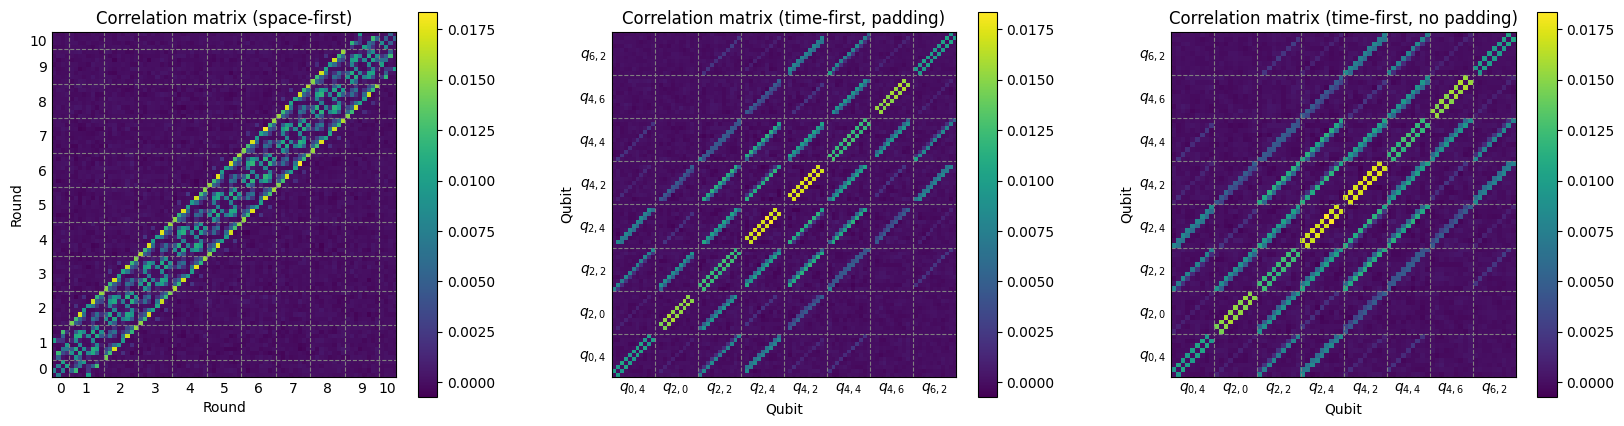

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.3)
plot(fig, axs[0], p_ij_s, "Correlation matrix (space-first)", "Round", calc_ticks_s(coords))
plot(fig, axs[1], p_ij_t1, "Correlation matrix (time-first, padding)", "Qubit", calc_ticks_t(qubits, rounds))
plot(fig, axs[2], p_ij_t2, "Correlation matrix (time-first, no padding)", "Qubit", calc_ticks_t(qubits, rounds - 2))
plt.show()

## S and T errors

In [11]:
def calc_t_errors(p_ij: np.ndarray, qubits: list[tuple[int, int]], distance: int):
    t_edges = np.array(
        [i[:-1] for i in np.split(np.append(p_ij.diagonal(1), 0), distance**2 - 1)]
    ).mean(axis=1)
    heatmap = np.full((distance * 2 + 1, distance * 2 + 1), np.nan)
    for (x, y), i in zip(qubits, t_edges):
        heatmap[x, y] = i
    return heatmap

t_heatmap = calc_t_errors(p_ij_t2, qubits, distance)

In [12]:
def midpoint(x, y):
    return (x[0] + y[0]) // 2, (x[1] + y[1]) // 2

def calc_s_errors(p_ij: np.ndarray, qubits: list[tuple[int, int]], distance: int):
    x_qubits = [q for q in qubits if (q[0] + q[1]) % 4 == 2]
    z_qubits = [q for q in qubits if (q[0] + q[1]) % 4 == 0]
    x_heatmap = np.full((distance * 2 + 1, distance * 2 + 1), np.nan)
    z_heatmap = x_heatmap.copy()
    for q_i, x_i in zip(qubits, np.split(p_ij, distance**2 - 1)):
        for q_j, x_j in zip(qubits, np.split(x_i, distance**2 - 1, axis=1)):
            if q_i in x_qubits and q_j in x_qubits and q_i != q_j:
                x_heatmap[*midpoint(q_i, q_j)] = x_j.mean()
            elif q_i in z_qubits and q_j in z_qubits and q_i != q_j:
                z_heatmap[*midpoint(q_i, q_j)] = x_j.mean()
    return x_heatmap, z_heatmap

sx_heatmap, sz_heatmap = calc_s_errors(p_ij_t2, qubits, distance)

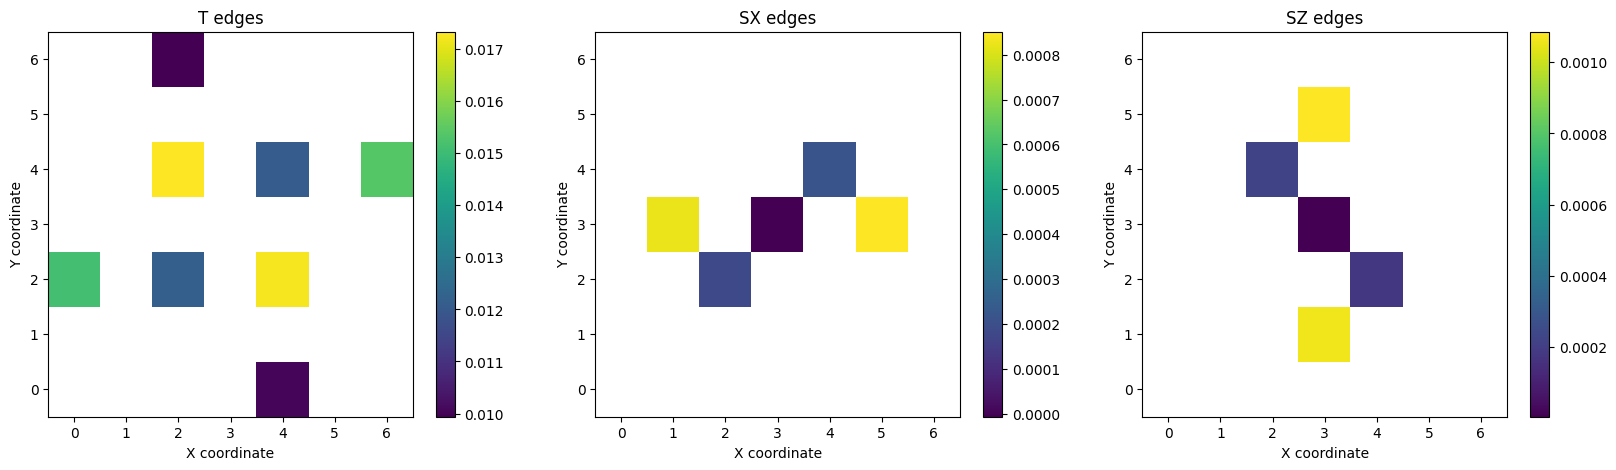

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for data, title, ax in zip(
    [t_heatmap, sx_heatmap, sz_heatmap],
    ["T edges", "SX edges", "SZ edges"],
    axs,
):
    im = ax.imshow(data, aspect="auto")
    fig.colorbar(im, ax=ax)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")

plt.show()